In [2]:
import torch
from torch.nn import functional as F
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision import models

import numpy as np

In [20]:
a = torch.rand((1,5))
b = torch.rand((1,5))
m = nn.MSELoss()
m(a,b)

tensor(0.0811)

In [185]:
model = models.resnet18(pretrained=True)

In [186]:
model.load_state_dict(torch.load("./model.pth.tar-100")["state_dict"])

<All keys matched successfully>

In [187]:
class FE(nn.Module):
    def __init__(self, model):
        super(FE, self).__init__()
        self.model = model

    def forward(self, x):
        for i in list(self.model.children()):
            # if type(i) != nn.Linear and type(i) != nn.AdaptiveAvgPool2d:
            if type(i) != nn.Linear:
                x = i(x)
        return x

In [188]:
f =FE(model)

In [189]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4

    def forward(self, x):
        x = self.model.bn1(self.model.conv1(x))
        x = self.model.maxpool(self.model.relu(x))
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.model.avgpool(x4)
        return x1

In [190]:
f = FeatureExtractor(model)

In [191]:
from PIL import Image
image = Image.open("./dog.jpg")

In [192]:
transform = transforms.Compose([
    transforms.Resize(224), # 缩放图片(Image)，保持长宽比不变，最短边为224像素
    transforms.CenterCrop(224), # 从图片中间切出224*224的图片
    transforms.ToTensor(), # 将图片(Image)转成Tensor，归一化至[0, 1]（直接除以255）
    # transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]) # 标准化至[-1, 1]，规定均值和标准差
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 常用标准化
])

In [193]:
image = transform(image)

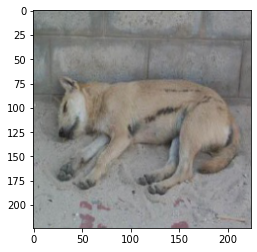

In [194]:
import matplotlib.pyplot as plt
img = np.transpose(image, (1,2,0))
plt.imshow(img)

In [195]:
image = np.expand_dims(image, 0)
image = torch.from_numpy(image)

In [196]:
image.shape

torch.Size([1, 3, 224, 224])

In [197]:
out = f(image)

In [198]:
out1, out2 = torch.chunk(out,2,dim=3)
out1.shape

torch.Size([1, 64, 56, 28])

In [199]:
def visualize_component(component, name='Component'):
    # Channel_wise Pooling --> B x 1 x H x W
    CP = torch.mean(component, dim=1, keepdim=True)
    B, C, H, W = CP.shape

    # min max normalization
    CP = CP.view(B, -1)
    CP = CP - CP.min(dim=1)[0].unsqueeze(1)
    CP = CP / CP.max(dim=1)[0].unsqueeze(1)
    CP = CP.view(B, 1, H, W)

    B, C, H, W = CP.shape
    # 先进行下采样（双线性插值）size=[a,b] 还是右对齐，(H,W)->(224,224)
    CP_up = torch.nn.functional.interpolate(CP, size=[224, 224], mode='bilinear').repeat(1, 3, 1, 1)  # repeat：还原到三通道
    img_out = CP_up
    # img_out = torch.cat([x_org, CP_up], dim=3)
    from torchvision.utils import make_grid, save_image
    save_image(make_grid(img_out, nrow=8), "./"+name+".jpg")

In [200]:
visualize_component(out1, name="1")
visualize_component(out2, name="2")
visualize_component(out, name="Total")

E:\Anaconda\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


torch.chunk(input, chunks, dim = 0)

torch.split(tensor, split_size_or_sections, dim = 0)


In [201]:
def c(x, dim=1):
    x1, x2 = torch.chunk(x, 2, dim)
    return torch.chunk(x, 2, dim)

In [202]:
x1= c(out)

In [203]:
a = torch.rand([16,256,1,1])

In [204]:
import torch.nn as nn
flatten = nn.Flatten(1,3)

In [205]:
flatten(a).shape

torch.Size([16, 256])